## Cryptocurrency analysis and Blackswan Detection

#### -This project is about doing MonteCarlo simulation to forecast prices using various transformation and statistical functions to better understand the data, Further it will touch surfaces about Blackswan detection

#### -We have used a modular functional design principles rather than classes beacuse we thought using classes would be unnecessary in this case as classes are best used to replicate real life scenerios. We also could not do alot of design principles becasue this project turned out to be research heavy and instead we thought to having to explore a priority, otherwise it was unlikely to finish the project with amazing results.

#### -Overall approach was to read alot of papers and understand what can be used and what is not necessary and initially it look us alot of time to understand these statistical transformation and funtions that can be used for better forecasting. Some of them are:

###### 1) Gumbel distribution :In probability theory and statistics, the Gumbel distribution (Generalized Extreme Value distribution Type-I) is used to model the distribution of the maximum (or the minimum) of a number of samples of various distributions. This distribution might be used to represent the distribution of the maximum level r in a particular year if there was a list of maximum values for the past ten years. It is useful in predicting the chance that an extreme event will occur, The potential applicability of the Gumbel distribution to represent the distribution of maxima relates to extreme value theory

###### 2) Kernel density estimation: In statistics, kernel density estimation (KDE) is a non-parametric way to estimate the probability density function of a random variable. Kernel density estimation is a fundamental data smoothing problem where inferences about the population are made, based on a finite data sample. 

###### 3) Box-Cox Transformation: In statistics, a power transform is a family of functions that are applied to create a monotonic transformation of data using power functions. This is a useful data transformation technique used to stabilize variance, make the data more normal distribution-like. The Box-Cox is part of this power transforms

#### -We pivoted from the origional idea as there were troubles handling data in btc as the values became really small and statistical function started giving thrash output, also black swan detection became really impossible as the output were not significant, so we decided to have general forecasting in USD and then do blackswam detection.

#### -This project was really crucial as it got us out of the comfort zone and understanding general financial stock terminologies and methods and then applying to the cryptocurrency, even if we think both are quite similliar but its too soon to say that, after this detailed analysis it was very easy to interpret that something big is going to happen in this space as this is just the nascent stages with alot of volatility.

#### -The code is tested and run for bitcoin,bitcoin cash, litecoin, ethereum, ethereum classic, Dash and some more. it does not work for crypto like ripple, steller as some statistical functions fail when the values are below 1 and need some different methods to handle them

#### -This will be an ongoing project and we have decided to keep exploring more even after submission of the project.

### Contributions

#### Anmol Gandhi : Wrote maximum code and inline code comments, docstrings and documentation

#### Harsh Mangal : Extracted data, data cleaning, review other teammates codes, updated Readme and presentation

In [33]:
%matplotlib inline
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
import seaborn as sns
import math 
from scipy.stats import norm
from scipy.special import boxcox, inv_boxcox
from scipy.stats import gaussian_kde
import numpy as np
from scipy.stats import gumbel_l
import datetime as dt

In [2]:
# This code chunk is used to read data and clean and process data.

global df
global crypto_month,crypto
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df = pd.read_csv('./Documents/all_currencies.csv', parse_dates=['Date'], index_col='Date', date_parser=dateparse)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df["pct_change"] = df["Close"].pct_change().fillna(0)


In [3]:
#Setting a fixed format for displaying any plot

colors = ["windows blue", "amber", "faded green", "dusty purple"]
sns.set(rc={"figure.figsize": (10,5), "axes.titlesize" : 18, "axes.labelsize" : 12, 
"xtick.labelsize" : 14, "ytick.labelsize" : 14 })

In [183]:

#Used this initially to check if we need to perform BOX-COX: Seasonal decomposition helps us to understand the 
#seasonal behavior and helps us understand if we need more transformation, it was almost always the case that BOX-COX 
#was necessary so commented and dint use it.

#def dickey_fuller():
#    #SEASONAL DECOMPOSITION
#    seasonal_decompose(crypto_month.Close, model='additive').plot()
#    print("Dickey–Fuller test for seasonal decomposition:",adfuller(crypto_month.Close)[1],2)
    

## Cryptocurrency Analysis and Monte Carlo Forecasting

### step 1: choose_currency()
###### This function is used to index the dataframe wrt to the crypto which is passed and then it can be resampled by D-Day, W-Week. As for crypto data, since it still doesnt have massive data its easier to have a detailed look by resampling it through Days.

### step 2: normalisation()
###### This function first uses a box-cox transformation to transform the time series into normal distribution, then we fit this data into a normal distribution funtion and then display a plot to understand the after-before effect of the box-cox and normal fit.

### step 3: monte_Carlo()
###### This function simulates the monte carlo scenerio for 1000 iterations, the parameters tuple is used to calculate the daily volitality and daily drift, later the price is calculated by using GBM, furthermore the data is then converted back again using inverse box-cox. All 1000 simulated scenerios are plotted for visual understanding
    
### step 4: most_likely_price()
##### This function is used to calculate the most likely price for the next year for the selected crypto, The function uses the Guassian Kernel desnity function to fit the data and then uses the probabilty density function to get the most likely price, it also shows a visual represention of KDE and Likely vs Current 


In [4]:
def choose_curreny(crypto):
    """
    input: crpto ---> String
    returns: crypto_month -----> DataFrame, crypto ----> String
    
    This function is used to index the dataframe wrt to the crypto which is passed and then it can be resampled 
    by D-Day, W-Week. As for crypto data, since it still doesnt have massive data its easier to have a detailed look
    by resampling it through Days.
    """
    
    c = df[df["Symbol"] == crypto]
    crypto_month = c[c.index.year > 2016].resample('D').mean()
    return crypto_month,crypto

In [5]:
crypto_month,crypto = choose_curreny("LTC")

In [6]:
def normalisation():
    """
    This function first uses a box-cox transformation to transform the time series into normal distribution,
    then we fit this data into a normal distribution funtion and then display a plot to understand the after-before
    effect of the box-cox and normal fit.
    
    returns: paramaters --> where parameters[0] = mean and parameters[1] = Sd of the fitted normal distrubition
    """
    
    #Applying BOX-COX Transformation to approximate into normal distribution
    crypto_month['close_box']= stats.boxcox(crypto_month.Close,2.5)
    crypto_month["pct change"] = (crypto_month.close_box.pct_change()+1).fillna(1)
    
    #Generating the mean and sd of the normal fit
    parameters = norm.fit(crypto_month['pct change'].fillna(1)-1)
    x = np.linspace(min(crypto_month["pct change"]-1), max(crypto_month["pct change"]-1), 100)

    # Generate the pdf (fitted distribution)
    fitted_pdf = norm.pdf(x,loc = parameters[0],scale = parameters[1])
    
    # Generate the pdf (normal distribution non fitted)
    normal_pdf = norm.pdf(x)
    
    #Generating the Plot
    plt.plot(x,fitted_pdf,"red",label="Fitted normal dist",linestyle="dashed", linewidth=2)
    plt.plot(x,normal_pdf,"blue",label="Normal dist", linewidth=2)
    plt.hist(crypto_month["pct change"] - 1,normed=1,color="b",alpha=.3, bins=200, label='Daily returns') 
    plt.title(crypto+" returns and normal fitting")
    plt.legend()
    plt.show()
    
    return parameters

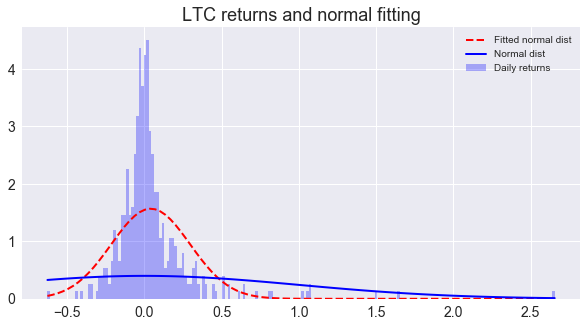

In [9]:
parameters = normalisation()

In [7]:
def monte_carlo(parameters):
    """
    input: parameters ---> tuple
    returns: inv_box_cox --> DataFrame
    
    This function simulates the monte carlo scenerio for 1000 iterations, the parameters tuple is used to calculate
    the daily volitality and daily drift, later the price is calculated by using GBM, furthermore the data is then
    converted back again using inverse box-cox. All 1000 simulated scenerios are plotted for visual understanding
    
    """
    
    #Calculating essential parameter for further forcasting
    crypto_month["pct change"] = (crypto_month.close_box.pct_change())
    daily_volatility = parameters[1]
    daily_drift = parameters[0]
    mean_drift = daily_drift - 0.5 * (daily_volatility)**2
    last_price = crypto_month["close_box"][-1]

    #Monte Carlo simulation 
    sim_df=pd.DataFrame()
    for x in range(1000):
        count = 0
        price_series = []
        last_price = crypto_month['close_box'][-1]
        for y in range(365):
            log_return = mean_drift + (daily_volatility * np.random.normal(0, 1))
            price = last_price * (math.e ** log_return)
            price_series.append(price)
            last_price = price
            count += 1
        sim_df[x] = price_series
    
    #Getting back to origional data using Inverse BOX-COX
    inv_box_cox=inv_boxcox(sim_df,2.5)
    
    #Plotting all 1000 iterations of Monte Carlo scenerio of forcasted price series
    plt.plot(inv_box_cox)
    plt.yscale('log')
    plt.xlabel('Days', size=20)
    plt.ylabel('Price ($) (log scale)', size=20)
    plt.title('Monte Carlo Simulation of '+crypto+' for next year', size=20)
    plt.show()
    
    return inv_box_cox

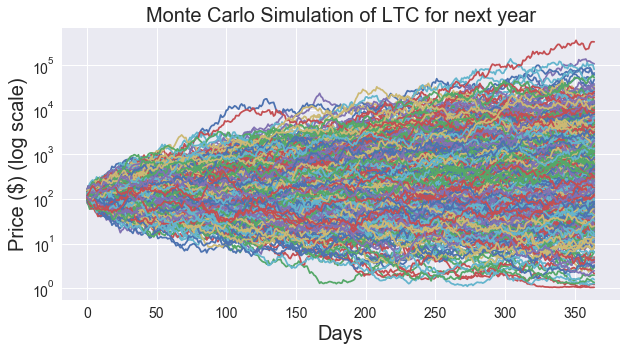

In [12]:
inv_box_cox = monte_carlo(parameters)

In [8]:
def most_likely_price(inv_box_cox):
    """
    input: inv_box_cox ---> DataFrame
    returns: nothing
    
    This function is used to calculate the most likely price for the next year for the selected crypto, 
    The function uses the Guassian Kernel desnity function to fit the data and then uses the probabilty density 
    function to get the most likely price, it also shows a visual represention of KDE and Likely vs Current 
    """
    
    #Finding out all the possible likely prices of all the 1000 simulations
    possible_prices = pd.DataFrame(inv_box_cox)
    possible_prices = possible_prices.iloc[-1,:]
    
    #Plotting the histogram for likely possible prices of the simulations
    fig, ax = plt.subplots()
    plt.hist(np.log(possible_prices),bins=25,density=True)
    xticks = plt.xticks()
    ticks = np.linspace(min(np.log(possible_prices)), max(np.log(possible_prices)), 10)
    plt.xticks(ticks, [str(int(np.exp(tick))) for tick in ticks]);

    #Using the Gaussian KDE(Kernel density estimation) and then using pdf function to get the most likely price
    kde = gaussian_kde(np.log(possible_prices))
    x = np.linspace(min(np.log(possible_prices)), max(np.log(possible_prices)), 25)
    ax.plot(x, kde.pdf(x), linewidth=3, c='orange', alpha=1, label='KDE density function')

   
    #Displaying Most likely Price for next year
    most_likely_price = np.exp(x[np.argmax(kde.pdf(x))])
    ax.vlines(np.log(most_likely_price), 0, kde.pdf(np.log(most_likely_price)), color='w')
    ax.annotate('Most likely price: ${}'.format(int(round(most_likely_price))), 
                xy=(np.log(most_likely_price), kde.pdf(np.log(most_likely_price))), 
                xytext=(11, 0.2),
                arrowprops=dict(facecolor='black', shrink=0.1),
                size=19)
    
    
    #Displaying Current price on the Plot
    current_price = crypto_month.Close[-1]
    ax.vlines(np.log(current_price), 0, kde.pdf(np.log(current_price)), color='w')
    ax.annotate('Current price: ${}'.format(int(round(current_price))), 
                xy=(np.log(current_price), 0), 
                xytext=(10, 0.1),
                arrowprops=dict(facecolor='black', shrink=0.0),
                size=14, 
                color='black')

    
    
    plt.xlabel('Price ($)', size=20)
    plt.ylabel('Density', size=20)
    plt.title('Distribution of '+crypto+' simulated prices for next year', size=20)
    plt.show()
    
    print("The 80% confidence interval is:" + str(possible_prices.quantile(.2)), str(possible_prices.quantile(.8)))

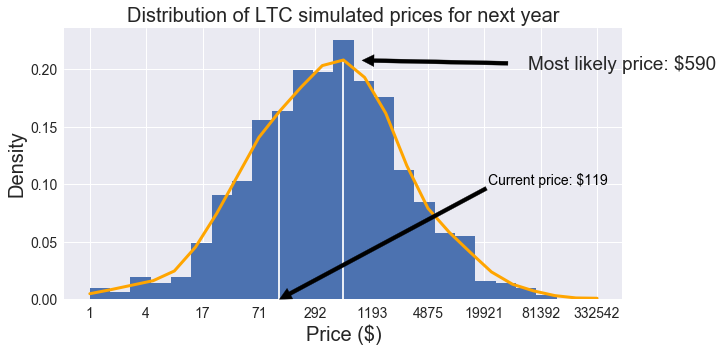

The 80% confidence interval is:79.03881387463878 1866.8256958842421


In [13]:
possible_prices = most_likely_price(inv_box_cox)


## Detection of Blackswans in Cryptocurrency Analysis

### step1: gumbel_distribution()
###### This function is used to fit the data into the gumbel distribution by initially extracting the all time minimumsof respective cryptos and then using Gumbel pdf to visualise how it fits into the data, the scaleG and locG parameters will further used to detect black swans

### step2: blackswan_detection()
###### This function is used to first filter out the cryptos which do not satisfy the criteria for the blackswan events further plotting the blackswan events and fitting the cdf of gumbel to determine the probabilty of an blackswan event occurance.

In [26]:
def gumbel_distribution():
    """
    returns: locG ----> float, scaleG ----> float
    
    This function is used to fit the data into the gumbel distribution by initially extracting the all time minimums
    of respective cryptos and then using Gumbel pdf to visualise how it fits into the data, the scaleG and locG 
    parameters will further used to detect black swans
    
    """
    
    #Setting up a new emply dataframe called df_black
    col = ['Date', 'Return','crypto']
    df_black = pd.DataFrame(columns=col)
    
    
    #Filling each row with minimum daily change, the date for that and the respective crypto
    for i in df["Symbol"].unique():
        rmin = df[df["Symbol"]==i]["pct_change"].sort_values()[0]
        tmin = df[df["Symbol"]==i]["pct_change"].sort_values().index[0]
        crypto = i
        df_black.loc[len(df_black)]=[tmin, rmin,crypto]  # add new row to df_black
    
    #Fitting the df_black data into gumbel distribution
    locG, scaleG = gumbel_l.fit(df_black["Return"])  # location, scale parameters
 
    dx = 0.0001
    x = [dx*i for i in range(-int(1/dx), int(1/dx)+1)] # Generating data for Z-value in Gumbel pdf formula
    x2 = x.copy()
    plt.figure(num=3, figsize=(9, 4))
    plt.hist(df_black["Return"], bins=30, normed=True, color="grey", 
                 label="Crypto Data")
    
    #Finding the gumbel probability function and using its values to see fitted values
    pdf1 = gumbel_l.pdf(x2, loc=locG, scale=scaleG)
    y = pdf1.copy()
    plt.plot(x2, y, 'r', linewidth=1, label="Gumbel PDF fit")
    plt.xlim([-1, 0])
    plt.xlabel('Daily loss [%]', fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.legend(loc=1)
    
    return locG, scaleG,df_black

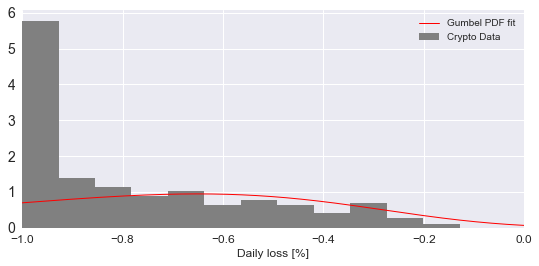

In [27]:
locG,scaleG,df_black = gumbel_distribution()

In [31]:
def blackswan_detection(locG,scaleG,df_black):
    """
    input: locG ----> float, scaleG ----> float
    
    This function is used to first filter out the cryptos which do not satisfy the criteria for the blackswan events
    further plotting the blackswan events and fitting the cdf of gumbel to determine the probabilty of an blackswan 
    event occurance.
    
    """

    # extract black swans from the df_black dataframe for every crypto satisfying the condition
    dfb = df_black[df_black["Return"] < locG+scaleG ]  
    dfb = dfb.set_index("Date")
    dfb = dfb.sort_index()
    dfb0 = dfb.copy()
    
    #Plotting the plot for possible black swans in the crypto space from 2013
    plt.figure(figsize=(13, 6))
    plt.plot(dfb["Return"]*100, '.r')
    plt.xlabel('Time Interval [%s to %s]' % (dfb.index[0], dfb.index[-1]), 
                   fontsize=14)
    plt.ylabel('Black Swan Magnitude [%]', fontsize=14)
    plt.title('Time Distribution of Black Swans of %g Crypto (L < %.1f%%)' % 
                  (len(dfb), (locG+scaleG)*100), fontsize=14)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.ylim([-100, 0])
    plt.xlim([dt.date(2013,1,1), dt.date(2017, 12, 1)])
    
    
    #Finding the CDF of the gumbel fit so that we can estimate its probability 
    Pr_bs = gumbel_l.cdf(locG+scaleG, loc=locG, scale=scaleG)
    print("The Probabilty of a blackswan event occuring is",round(Pr_bs*100,2),"%")
    print(locG, scaleG, locG-scaleG, locG+scaleG)

The Probabilty of a blackswan event occuring is 93.4 %
-0.6503743243087613 0.3891822560366457 -1.039556580345407 -0.2611920682721156


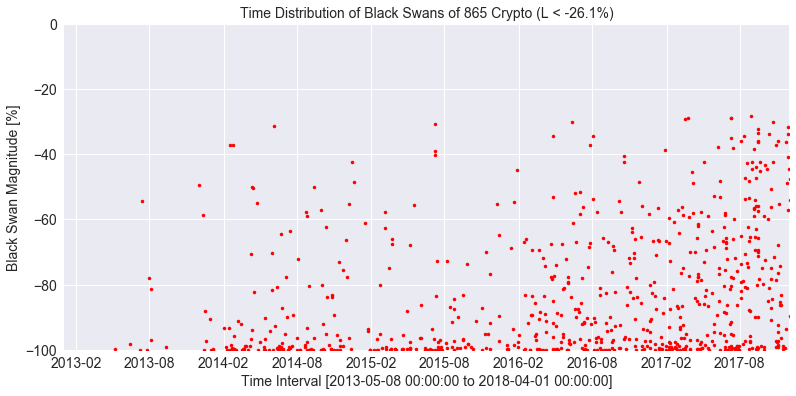

In [32]:
blackswan_detection(locG,scaleG,df_black)

#### The Gumbel pdf’s location parameter (peak) is at -65.03% with scale of 38.9%. Using an analogy to Normal distribution, we define two brackets, namely: a-b and a+b to be -103% and -26%. Given that we define Blackswan event with a daily loss of  L<a+b magnitube. Based on this data sample we find that 93.4% cryptos meet this criteria which is less than -26.1% daily loss and hence we can infer that the probability of a blackswan event occuring the next day in any of the 865 cryptos is 93.4%

##### Gumbel distribution :In probability theory and statistics, the Gumbel distribution (Generalized Extreme Value distribution Type-I) is used to model the distribution of the maximum (or the minimum) of a number of samples of various distributions. This distribution might be used to represent the distribution of the maximum level r in a particular year if there was a list of maximum values for the past ten years. It is useful in predicting the chance that an extreme event will occur, The potential applicability of the Gumbel distribution to represent the distribution of maxima relates to extreme value theory

##### Kernel density estimation: In statistics, kernel density estimation (KDE) is a non-parametric way to estimate the probability density function of a random variable. Kernel density estimation is a fundamental data smoothing problem where inferences about the population are made, based on a finite data sample. 

##### Box-Cox Transformation: In statistics, a power transform is a family of functions that are applied to create a monotonic transformation of data using power functions. This is a useful data transformation technique used to stabilize variance, make the data more normal distribution-like. The Box-Cox is part of this power transforms